### Notebook setup

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [34]:
%matplotlib inline

In [35]:
def plot_feature_importance(features, tree):
    """
    Display a bar chart of the importance of each feature 
    in a decision tree 
    
    Args:
        features: the feature names 
        tree: the trained decision tree
        
    Returns:
        None
    """
    
    d = {f: i for f, i 
         in zip(features, tree.feature_importances_)}
    
    importances = pd.DataFrame(d, orient="index")
    importances.rename(columns={0: "gini-importance"})
    
    importances.sort_values(by="gini-importance").plot(kind="bar")

### Load data & EDA

Load the data and examine the data types and first few rows.

In [36]:
df = pd.read_csv("data/train_LZdllcl.csv")

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


In [37]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


Examine summary statistics and distributions for the numeric colimns.

In [38]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


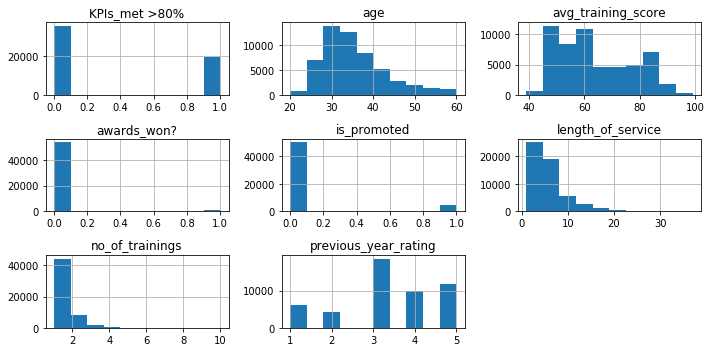

In [46]:
df.hist(figsize=(10, 5))
plt.tight_layout()

Nothing above looks too surprising. The mean of *is_promoted* shows that 8.5% of employees in the dataset are promoted, so there is a class imbalance, as expected.

Let's make sure that *employee_id* is always unique and then drop that feature.

In [39]:
df.employee_id.nunique() == df.employee_id.count()

True

In [40]:
df = df.drop("employee_id", axis=1)

There are a 

In [50]:
# we shouldn't need to fillna, right?
# df["previous_year_rating"].fillna(3, inplace=True)

Examine categorical features.

In [49]:
df.describe(include="O")

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


### Single decision tree

Let's see what kind of performance we can achieve with a single tree.

In [43]:
X = pd.get_dummies(df.drop("is_promoted", axis=1))
y = df["is_promoted"]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [57]:
dt = DecisionTreeClassifier(max_depth=8)

In [58]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

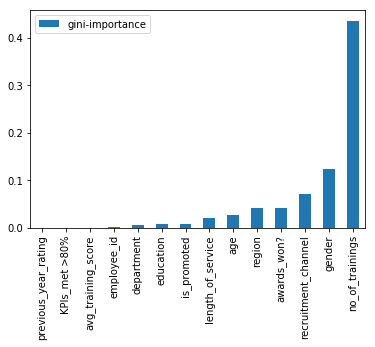

In [59]:
d = { c: f  for c, f in zip(df.columns, dt.feature_importances_) }
importances = pd.DataFrame.from_dict(d, orient="index").rename(columns={0: "gini-importance"})
importances.sort_values(by="gini-importance").plot(kind="bar")

In [60]:
from graphviz import Source
from sklearn import tree

graph = Source( tree.export_graphviz(dt, out_file=None, feature_names=X.columns))
png_bytes = graph.pipe(format="png")

with open("dtree.png", "wb") as f:
    f.write(png_bytes)

In [68]:
pred = dt.predict(X_test)
len(pred[pred == 1]) / len(pred)

0.022441160372194856

In [73]:
from sklearn.metrics import confusion_matrix, f1_score

In [72]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
(tn, fp, fn, tp)

(10023, 31, 693, 215)

In [74]:
f1_score(y_test, pred)

0.37261698440207974

In [100]:
from sklearn.model_selection import GridSearchCV

params = { 
    "max_depth": range(2, 20, 2),
    "min_impurity_decrease": [0, 0.01, 0.005, 0.0025],
    "min_samples_split": range(2, 20, 2),
}
clf = GridSearchCV(DecisionTreeClassifier(), params, n_jobs=2, cv=5, scoring="f1")
clf.fit(X_train, y_train)
dt_best = clf.best_estimator_

In [101]:
clf.best_score_, clf.best_params_

(0.48493367906169754,
 {'max_depth': 18, 'min_impurity_decrease': 0, 'min_samples_split': 18})

In [102]:
pred = dt_best.predict(X_test)
len(pred[pred == 1]) / len(pred)

0.043605181536216016

In [103]:
confusion_matrix(y_test, pred).ravel()

array([9906,  148,  578,  330])

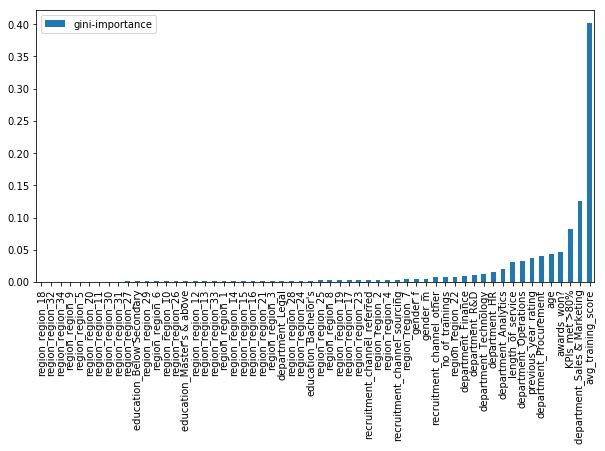

In [95]:
d = { c: f  for c, f in zip(X.columns, dt_best.feature_importances_) }
importances = pd.DataFrame.from_dict(d, orient="index").rename(columns={0: "gini-importance"})
importances.sort_values(by="gini-importance").plot(kind="bar", figsize=(10, 5))

So it looks like we can get to an f1 score of about 50% so far. What if we address the class imbalance?

In [105]:
print(len(df[df.is_promoted == 1]))
len(df[df.is_promoted == 0])

4668


50140

In [22]:
df_major = df[df.is_promoted == 0]
df_minor = df[df.is_promoted == 1]

In [23]:
from sklearn.utils import resample

df_minor_up = resample(df_minor, replace=True, n_samples=30000, random_state=42)

In [24]:
df_up = pd.concat([df_major, df_minor_up])

In [25]:
len(df_up[df_up.is_promoted == 1])

30000

In [33]:
df_up.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [34]:
X = pd.get_dummies(df_up.drop(["is_promoted", "employee_id"], axis=1))
y = df_up["is_promoted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(max_depth=8)

dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

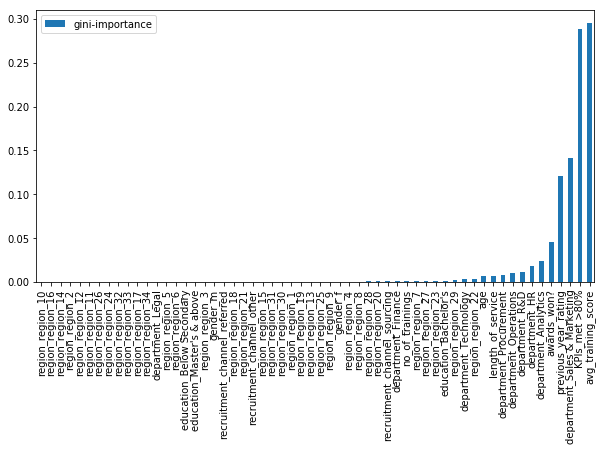

In [35]:
d = { c: f  for c, f in zip(X.columns, dt.feature_importances_) }
importances = pd.DataFrame.from_dict(d, orient="index").rename(columns={0: "gini-importance"})
importances.sort_values(by="gini-importance").plot(kind="bar", figsize=(10, 5))

In [36]:
from sklearn.model_selection import GridSearchCV

params = { 
    "max_depth": range(2, 20, 2),
    "min_impurity_decrease": [0, 0.01, 0.005, 0.0025],
    "min_samples_split": range(2, 20, 2),
}
clf = GridSearchCV(DecisionTreeClassifier(), params, n_jobs=2, cv=5, scoring="f1")
clf.fit(X_train, y_train)
dt_best = clf.best_estimator_

In [37]:
clf.best_score_, clf.best_params_

(0.8243972115487346,
 {'max_depth': 18, 'min_impurity_decrease': 0, 'min_samples_split': 2})

In [38]:
pred = dt_best.predict(X_test)
len(pred[pred == 1]) / len(pred)

0.4245071125530322

Well that's better. What if we try a random forest?